# Your info

Full name:Ali Sedaghi

Student ID:97521378

Notice: **You can add new cells for each part.**

# Q1.A. Kohonen

In [26]:
# Utility functions and Imports

import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def euclidean_distance(u, v):
  return np.linalg.norm(u - v)

In [27]:
class SOM():

  def __init__(self, width, height, ch):
    # Shape of Map
    self.x = width
    self.y = height
    self.ch = ch

    # Nodes (units) in map
    self.units = None

    # Neighborhood units Weights
    self.weights = None

    self.x_delta = None
    self.y_delta = None

    # Neighborhood Radius
    self.radius = None
    self.sigma = None

    # Neighborhood Radius Decay Rate
    self.radius_dr = None

    # Learning Rate
    self.learning_rate_0 = None
    self.learning_rate = None

    # Learning Rate Decay Rate
    self.learning_dr = None

    # a Vector of pixels of shape (m, height, width, ch)
    self.input = None

    self.iterations = None
    self.batch_size = None
    
  def init_decay_rate(self, learning_dr, radius_dr):
    self.learning_dr = learning_dr
    self.radius_dr = radius_dr

  def update_learning_rate(self, iteration):
    self.learning_rate = self.learning_rate_0 / (1. + self.learning_dr * iteration)

  def update_sigma(self, iteration):
    self.sigma = self.radius / (1. + self.radius_dr * iteration)

  def init_units(self):
    # Init randomly
    input_average = np.mean(self.input) / 0.5
    random_units = np.random.rand(self.y, self.x, self.ch) * input_average

    # Zero padding
    zero_pad_units = np.zeros((
      self.y + 2 * self.radius,
      self.x + 2 * self.radius,
      self.ch
    ))

    zero_pad_units[
      self.radius : self.radius + self.y,
      self.radius : self.radius + self.x
    ] = random_units.copy()

    self.units = zero_pad_units

  def make_neighborhood(self, iteration):
    size = self.radius * 2
    self.weights = np.full((size * size, self.ch), 0.0)
    p1 = 1.0 / (2 * math.pi * self.sigma ** 2)
    pdiv = 2.0 * self.sigma ** 2

    y_delta = []
    x_delta = []

    for y in range(size):
      for x in range(size):
        ep = -1.0 * ((x - self.radius) ** 2.0 + (y - self.radius) ** 2.0) / pdiv
        value = p1 * math.e ** ep
        self.weights[y * size + x] = value
        y_delta.append(y - int(self.radius))
        x_delta.append(x - int(self.radius))

    self.x_delta = np.array(x_delta, dtype=np.int32)
    self.y_delta = np.array(y_delta, dtype=np.int32)

    self.weights -= self.weights[size // 2]

    # Set negative weights to zero
    self.weights[self.weights < 0] = 0

    # Normalize weight vector
    self.weights /= np.max(self.weights)

  # Finding Best Matching Unit (BMU)
  def find_bmu(self, data):
    min_distance = None
    bmu_x = None
    bmu_y = None

    for y in range(self.y):
      for x in range(self.x):
        mu = self.units[
          y + self.radius,
          x + self.radius
        ]
        distance = euclidean_distance(data, mu)
        if min_distance is None or min_distance > distance:
          min_distance = distance
          bmu_x = x
          bmu_y = y

    bmu = {
      'y': bmu_y,
      'x': bmu_x
    }
    return bmu, min_distance

  def update_units(self, bmu_array):
    for i in range(bmu_array.shape[0]):
      unit_y = bmu_array[i, 0]
      unit_x = bmu_array[i, 1]
      data_index = bmu_array[i, 2]
      data = self.input[data_index]
        
      old = self.units[
        unit_y + self.y_delta + self.radius,
        unit_x + self.x_delta + self.radius
      ]

      diff = (np.expand_dims(data, axis=0) - old)
      updates = self.weights * self.learning_rate * diff
        
      self.units[
        unit_y + self.y_delta + self.radius,
        unit_x + self.x_delta + self.radius,
        :
      ] += updates

  def remove_zero_pad(self):
    self.units = self.units[
      self.radius : self.radius + self.y,
      self.radius : self.radius + self.x
  ]
    
  def fit(
    self,
    input,
    iterations,
    batch_size,
    learning_rate,
    radius
  ):

    self.input = input
    self.iterations = iterations
    self.batch_size = batch_size
    self.learning_rate_0 = learning_rate
    self.learning_rate = learning_rate
    self.radius = int(radius)
    self.sigma = radius

    input_count = self.input.shape[0]
    input_indexes = np.arange(input_count)
    batch_count = math.ceil(input_count / self.batch_size)

    self.init_units()

    for i in range(self.iterations):
      np.random.shuffle(input_indexes)
      total_distance = 0
      total_count = 0
      self.make_neighborhood(i)

      for b in range(batch_count):
        steps_in_batch = self.batch_size
        steps_left = input_count - b * self.batch_size
        if steps_left < self.batch_size:
          steps_in_batch = steps_left
          
        bmu_array = np.zeros((steps_in_batch, 3), dtype=np.int32)

        for s in range(steps_in_batch):
          total_count += 1
          data_index = input_indexes[b * self.batch_size + s]
          data = self.input[data_index]
          bmu, min_distance = self.find_bmu(data)
          bmu_array[s, 0] = bmu['y']
          bmu_array[s, 1] = bmu['x']
          bmu_array[s, 2] = data_index
          total_distance += min_distance

        # Update units weights in neighborhood after every batch
        self.update_units(bmu_array)

      # Print reports after every iteration
      print('Iteration:', i, 'Average distance:', total_distance / input_count)

      # Decay learning rate after every iteration
      self.update_learning_rate(i + 1)

      # Decay neighborhood radius (sigma) after every iteration
      self.update_sigma(i + 1)

    # Final units weights after all iterations  
    self.remove_zero_pad()

  def get_units(self):
    return self.units

In [28]:
# Dataset and Hyperparameters

dataset = (np.random.standard_normal([1600, 3]) * 255).astype(np.uint8)
untrainded_map = dataset.reshape(40, 40, 3).astype(np.uint8)

WIDTH = 40
HEIGHT = 40
DEPTH = 3
ITERATIONS = 20
BATCH_SIZE = 40
LEARNING_RATE = 0.25
RADIUS = min(WIDTH, HEIGHT) / 1.3

som = SOM(WIDTH, HEIGHT, DEPTH)

In [29]:
# Without Learning rate decay
# Without Neighboorhood radius decay

LEARNING_RATE_DECAY = 0
RADIUS_DECAY = 0

som.init_decay_rate(LEARNING_RATE_DECAY, RADIUS_DECAY)
som.fit(dataset, ITERATIONS, BATCH_SIZE, LEARNING_RATE, RADIUS)
train1 = som.get_units().copy().astype(np.uint8)

Iteration: 0 Average distance: 72.1639739287166
Iteration: 1 Average distance: 72.37302008455934
Iteration: 2 Average distance: 72.09280814489802
Iteration: 3 Average distance: 73.11658934074043
Iteration: 4 Average distance: 73.90894142508256
Iteration: 5 Average distance: 71.39676159932158
Iteration: 6 Average distance: 72.19543031404736
Iteration: 7 Average distance: 73.12504289968619
Iteration: 8 Average distance: 72.72490823039307
Iteration: 9 Average distance: 73.25221980089907
Iteration: 10 Average distance: 73.11538699171389
Iteration: 11 Average distance: 73.38925283658304
Iteration: 12 Average distance: 72.96262391116952
Iteration: 13 Average distance: 73.87917091423597
Iteration: 14 Average distance: 72.57298884091702
Iteration: 15 Average distance: 70.974109974335
Iteration: 16 Average distance: 72.71358863805642
Iteration: 17 Average distance: 73.65370270951826
Iteration: 18 Average distance: 75.23644121230073
Iteration: 19 Average distance: 73.20636049582622


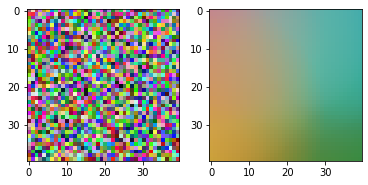

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(untrainded_map)
ax2.imshow(train1)

# Q1.B. Kohonen

In [31]:
# With Learning rate decay
# Without Neighboorhood radius decay

LEARNING_RATE_DECAY = LEARNING_RATE / ITERATIONS
RADIUS_DECAY = 0

som.init_decay_rate(LEARNING_RATE_DECAY, RADIUS_DECAY)
som.fit(dataset, ITERATIONS, BATCH_SIZE, LEARNING_RATE, RADIUS)
train2 = som.get_units().copy().astype(np.uint8)

Iteration: 0 Average distance: 72.64714365052171
Iteration: 1 Average distance: 72.49358588401695
Iteration: 2 Average distance: 72.39111915454774
Iteration: 3 Average distance: 73.05297076904482
Iteration: 4 Average distance: 74.19011832730662
Iteration: 5 Average distance: 72.29136259103478
Iteration: 6 Average distance: 72.12815255012505
Iteration: 7 Average distance: 72.21273548345572
Iteration: 8 Average distance: 71.84119106143685
Iteration: 9 Average distance: 72.51048088662056
Iteration: 10 Average distance: 73.23141971312867
Iteration: 11 Average distance: 70.1037448569371
Iteration: 12 Average distance: 71.96687177483744
Iteration: 13 Average distance: 74.02099796810218
Iteration: 14 Average distance: 73.88126410407035
Iteration: 15 Average distance: 71.0806978357194
Iteration: 16 Average distance: 72.02324636661723
Iteration: 17 Average distance: 72.25445465008512
Iteration: 18 Average distance: 73.73241212970903
Iteration: 19 Average distance: 73.4541541333654


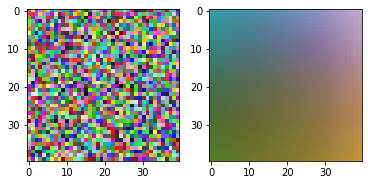

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(untrainded_map)
ax2.imshow(train2)

In [33]:
# With Learning rate decay
# With Neighboorhood radius decay

LEARNING_RATE_DECAY = LEARNING_RATE / ITERATIONS
RADIUS_DECAY = RADIUS / ITERATIONS

som.init_decay_rate(LEARNING_RATE_DECAY, RADIUS_DECAY)
som.fit(dataset, ITERATIONS, BATCH_SIZE, LEARNING_RATE, RADIUS)
train3 = som.get_units().copy().astype(np.uint8)

Iteration: 0 Average distance: 71.37648653098387
Iteration: 1 Average distance: 61.891411611915416
Iteration: 2 Average distance: 46.36858129256371
Iteration: 3 Average distance: 37.33178805542299
Iteration: 4 Average distance: 31.280952176899813
Iteration: 5 Average distance: 27.82532160887247
Iteration: 6 Average distance: 24.58019490829052
Iteration: 7 Average distance: 22.34994608679582
Iteration: 8 Average distance: 20.412509871474327
Iteration: 9 Average distance: 19.063345980232558
Iteration: 10 Average distance: 17.806428912309226
Iteration: 11 Average distance: 16.925349325296345
Iteration: 12 Average distance: 16.04912978162243
Iteration: 13 Average distance: 15.41556415189356
Iteration: 14 Average distance: 14.777650470791421
Iteration: 15 Average distance: 14.096011916416874
Iteration: 16 Average distance: 13.577068824940367
Iteration: 17 Average distance: 13.102282588768391
Iteration: 18 Average distance: 12.633216873045681
Iteration: 19 Average distance: 12.21583474758278

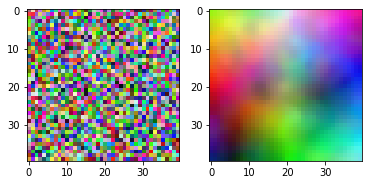

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(untrainded_map)
ax2.imshow(train3)

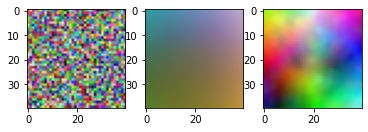

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(untrainded_map)
ax2.imshow(train2)
ax3.imshow(train3)

# Q2.A. MLP

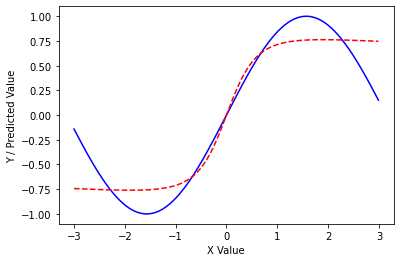

In [36]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pylab as plt

x = np.arange(-3, 3, 0.01)
y = np.sin(x)

model = Sequential()
model.add(Dense(5, input_shape=(1,), activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(x, y, epochs=50, batch_size=30, verbose=0)

y_predict = model.predict(x)

plt.plot(x, y, 'b', x, y_predict, 'r--')
plt.ylabel('Y / Predicted Value')
plt.xlabel('X Value')
plt.show()

# Q2.B. RBF

In [37]:
# Utility functions and Imports

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def rbf(x, center, radius):
  return np.exp(-1 / (2 * radius ** 2) * (x - center) ** 2)

# We used an already impelemented kmeans clustering function
# It was allowed to use 3rd party module for k-means
def kmeans(X, k):
  clusters = np.random.choice(np.squeeze(X), size=k)
  prevClusters = clusters.copy()
  stds = np.zeros(k)
  converged = False

  while not converged:
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    for i in range(k):
      pointsForCluster = X[closestCluster == i]
      if len(pointsForCluster) > 0:
        clusters[i] = np.mean(pointsForCluster, axis=0)

    converged = np.linalg.norm(clusters - prevClusters) < 1e-6
    prevClusters = clusters.copy()

  distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
  closestCluster = np.argmin(distances, axis=1)

  clustersWithNoPoints = []
  for i in range(k):
    pointsForCluster = X[closestCluster == i]
    if len(pointsForCluster) < 2:
      clustersWithNoPoints.append(i)
      continue
    else:
      stds[i] = np.std(X[closestCluster == i])

  if len(clustersWithNoPoints) > 0:
    pointsToAverage = []
    for i in range(k):
      if i not in clustersWithNoPoints:
        pointsToAverage.append(X[closestCluster == i])

    pointsToAverage = np.concatenate(pointsToAverage).ravel()
    stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

  return clusters, stds

In [38]:
class RBF():
  def __init__(self, k):
    self.k = k
    self.w = np.random.randn(k)
    self.b = np.random.randn(1)

    self.centers = None
    self.stds = None

    self.iterations = None
    self.learning_rate = None

  def predict(self, x):
    y_predict = []
    for i in range(x.shape[0]):
      z = np.array([rbf(x[i], center, sigma) for center, sigma, in zip(self.centers, self.stds)])
      a = z.T.dot(self.w) + self.b
      y_predict.append(a)
    return np.array(y_predict)

  def update_parameters(self, a, error):
    self.w = self.w - self.learning_rate * a * error
    self.b = self.b - self.learning_rate * error

  def fit(self, x, y, iterations, learning_rate):
    self.iterations = iterations
    self.learning_rate = learning_rate
    self.centers, self.stds = kmeans(x, self.k)

    # Stochastic Gradient Descent
    for i in range(self.iterations):
      for j in range(x.shape[0]):
        
        # Forward propagation
        z = np.array([rbf(x[j], center, sigma) for center, sigma, in zip(self.centers, self.stds)])
        a = z.T.dot(self.w) + self.b

        # Backward propagation
        difference = y[j] - a
        loss = (difference.flatten() ** 2) / 2
        error = (-1) * difference.flatten()

        # Update parameters
        self.update_parameters(z, error)

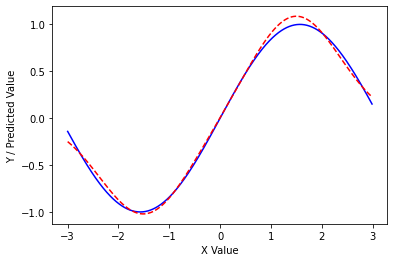

In [39]:
ITERATIONS = 500
LEARNING_RATE = 0.01

my_rbf = RBF(k=2)
my_rbf.fit(x, y, ITERATIONS, LEARNING_RATE)
 
y_predict = my_rbf.predict(x)
 
plt.plot(x, y, 'b', x, y_predict, 'r--')
plt.ylabel('Y / Predicted Value')
plt.xlabel('X Value')
plt.show()

# Q2.C. Compare

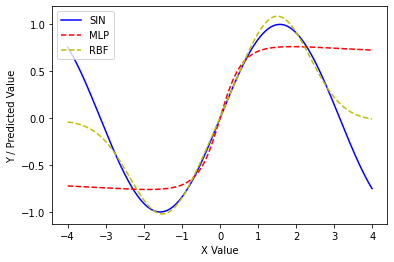

In [40]:
x_new = np.arange(-4, 4, 0.01)
y_new = np.sin(x_new)

y_mlp = model.predict(x_new)
y_rbf = my_rbf.predict(x_new)

plt.plot(x_new, y_new, 'b', x_new, y_mlp, 'r--', x_new, y_rbf, 'y--')
plt.ylabel('Y / Predicted Value')
plt.xlabel('X Value')
plt.legend(['SIN', 'MLP', 'RBF'], loc='upper left')
plt.show()

# <font color='red'>Submission</font>

1. Sign up in [Gradescope](https://www.gradescope.com) with proper name and student ID and use the following code to join the class: <font color='red'>**D5372R**</font>
2. Fill in your full name (seperated by single spaces) and student ID in the beginning of this notebook.
3. After you're done with this notebook, you should do the following:
  - Clear all outputs of the notebook.
  ![clear all outputs](https://i.ibb.co/y6FrttB/Screen-Shot-2021-03-21-at-01-51-42.png)
  - Run all of the cells (if you skipped a question just leave the cell unchanged), and make sure all of your outputs are correct.
  ![run all](https://i.ibb.co/cgRcBZ0/Screen-Shot-2021-03-21-at-01-54-58.png)
  - Save your notebook.
  
  - If you're using Colab, download your notebook.
  ![download ipynb](https://i.ibb.co/2KxYM6K/Screen-Shot-2021-03-21-at-02-03-50.png)
  
  - Put the notebook file you just downloaded and `convert.py` in the same folder run the following command:
  ```bash
  python convert.py
  ```
  This will export your code for each question into a `.py` file.
   

  according to the question number.
  - There are 2 assignments in Gradescope: 

    You should upload your **codes** and your **notebook** in `HW2` section and your final report for all of the questions as a **single pdf** file in `HW2 - Report`. Autograder will automatically check for:
    - `CI992_HW2.ipynb`
    - `Q1.A. Kohonen.py`
    - `Q1.B. Koohonen.py`
    - `Q2.A. MLP.py`
    - `Q2.B. RBF.py`
    - `Q2.C. Compare.py`
    - Your name and ID in the beginning of `.ipynb` file.

    It is important that you <font color='red'>**don't**</font> change the names of these files before submission.

4. If you pass the autograder, you're good to go.